In [548]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

### Getting data information:

In [549]:
''' Get information about the dataset '''
words = open('names.txt', 'r').read().splitlines()
random.shuffle(words)
print('First 8 words in file:\n', words[:8])
print('\nTotal words in file: ', len(words))

First 8 words in file:
 ['kamilia', 'karma', 'germaine', 'syah', 'alaylah', 'rashaan', 'yovanny', 'kandice']

Total words in file:  32033


### Creating useful mappings:

In [550]:

''' Create mappings between characters and integers '''
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print('\nMapping string to integer: ', stoi)
print('Mapping integer to string: ', itos)


Mapping string to integer:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Mapping integer to string:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Building the dataset:

In [551]:
''' Building the dataset '''
# Takes in a list of names and an int which determines 
# how many previous chars are used for the prediction.
# Returns the inputs (X) and labels (Y) of the dataset
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

### Defining model parameters:

In [558]:
def build_model(block_size, features, neurons, verbose=1):
    g = torch.Generator().manual_seed(2147483647) # for determistic results

    ''' Look up table C '''
    C = torch.randn((27, features), generator=g)

    ''' Weights and biases '''
    W1 = torch.randn((block_size * features, neurons), generator=g) * (5/3) / (block_size * features)**0.5
    b1 = torch.randn(neurons, generator=g) * 0.01

    W2 = torch.randn((neurons, 27), generator=g) * 0.01
    b2 = torch.randn(27, generator=g) * 0

    ''' Parameters '''
    parameters = [C, W1, b1, W2, b2]

    ''' Telling pytorch that all parameters require a gradient '''
    for p in parameters:
        p.requires_grad = True

    if verbose > 0: print('Number of parameters:', sum(p.nelement() for p in parameters))

    return parameters

### Training model function:

In [574]:

def train_model(params, inputs, labels, step_size=0.1, batch_size=50, epochs=100):

    losses, passes = [], []
    for i in range(epochs):
        C, W1, b1, W2, b2 = params[0], params[1], params[2], params[3], params[4]
        ''' Contructing a minibatch '''
        ix = torch.randint(0, inputs.shape[0], (batch_size,), generator=g)

        ''' Forward Pass: '''
        # Embedding
        emb = C[inputs[ix]]
        #logits
        h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
        logits = h @ W2 + b2
        #Loss
        loss = F.cross_entropy(logits, labels[ix])

        ''' Backward Pass: '''
        # Reinitialize gradients
        for p in params:
            p.grad = None
        # Calculate the new gradients
        loss.backward()
        # Slightly adjust parameters against gradient direction
        for p in params:
            p.data -= step_size * p.grad

        if i % 10000 == 0: print(i, '/', epochs, '---->', loss.item())
                
        losses.append(loss.item())
        passes.append(i)

    ''' Getting final lost by doing a final forward pass '''
    # Embedding
    emb = C[inputs[ix]]
    #logits
    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
    logits = h @ W2 + b2
    #Loss
    loss = F.cross_entropy(logits, labels[ix])
    losses.append(loss.item())
    passes.append(passes[-1] + 1)
    print(epochs, '/', epochs, '---->', loss.item())

    ''' Plot the loss progess '''
    plt.plot(passes, losses)

    return params, losses, passes

    

### Creating the training and testing datasets:

In [594]:
''' Creating the train and test datasets '''
split = 0.9 # percentage of the words used to train the model
block_size = 7 # amount of characters used for the prediction
words_train = round(split * len(words))

x_train, y_train = build_dataset(words[:words_train], block_size)
x_test, y_test = build_dataset(words[words_train:], block_size)

Number of parameters: 19897
0 / 400000 ----> 3.301945209503174
10000 / 400000 ----> 2.6027326583862305
20000 / 400000 ----> 2.012281894683838
30000 / 400000 ----> 2.3746745586395264
40000 / 400000 ----> 2.167807102203369
50000 / 400000 ----> 2.0118424892425537
60000 / 400000 ----> 1.9232910871505737
70000 / 400000 ----> 2.4639787673950195
80000 / 400000 ----> 1.5702052116394043
90000 / 400000 ----> 2.133105754852295
100000 / 400000 ----> 1.909003496170044
110000 / 400000 ----> 2.238736152648926
120000 / 400000 ----> 1.9561896324157715
130000 / 400000 ----> 2.061342477798462
140000 / 400000 ----> 2.158285617828369
150000 / 400000 ----> 1.8245004415512085
160000 / 400000 ----> 2.154759168624878
170000 / 400000 ----> 2.202371120452881
180000 / 400000 ----> 1.7675176858901978
190000 / 400000 ----> 2.188809394836426
200000 / 400000 ----> 1.8443384170532227
210000 / 400000 ----> 2.234003782272339
220000 / 400000 ----> 1.8830136060714722
230000 / 400000 ----> 1.885284662246704
240000 / 400000

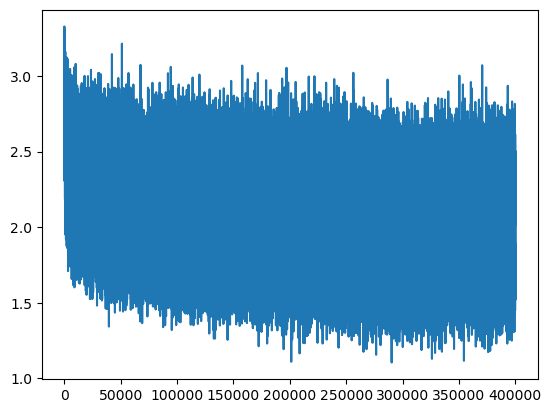

In [595]:
'''' Build model '''
features = 10
neurons = 200
model = build_model(block_size, features, neurons)

''' Train model '''
batch_size = 32
epochs = 400000
step_size = 0.01
model, losses, passes = train_model(model, x_train, y_train, step_size, batch_size, epochs)


In [596]:
#Expected loss:
-torch.tensor(1/27.0).log()

tensor(3.2958)

### Loss on test set:

In [597]:
C, W1, b1, W2, b2 = model[0], model[1], model[2], model[3], model[4]
# Embedding
emb = C[x_test]
#logits
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
#Loss
loss = F.cross_entropy(logits, y_test)
loss.item()

2.0646114349365234

### Sampling from the model:

In [598]:
for _ in range(20): # sample 20 words

    out = []
    context = [0] * block_size # inputs
    while True:
        # Forward pass:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # Sample from probability distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

nox.
zoha.
kyavik.
danni.
nelsiya.
zalier.
rarren.
amir.
chored.
inrrein.
tafik.
blekshidel.
lawin.
jancay.
ayrya.
huntli.
johntraellea.
podis.
kayleef.
gavin.


# First attempt at model

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for determistic results

''' Look up table C '''
C = torch.randn((27, 2), generator=g)

''' Weights and biases '''
W1 = torch.randn((6, 100), generator=g) # for 3 characters, 2 features per character, 100 neurons
b1 = torch.randn(100, generator=g) # for 100 neurons

W2 = torch.randn((100, 27), generator=g) #100 inputs, 27 possible character predictions
b2 = torch.randn(27, generator=g) # 27 possible character predictions

''' Parameters '''
parameters = [C, W1, b1, W2, b2]

In [ ]:
print('Number of parameters:', sum(p.nelement() for p in parameters))

Number of parameters: 3481


## Training the model:

In [329]:
''' Telling pytorch that all parameters require a gradient'''
for p in parameters:
    p.requires_grad = True

In [304]:
''' keeping track of loss in order to plot it later'''
losses = []
passes = []

### Gradient descent

In [305]:
for i in range(1000):

    ''' Contructing a minibatch '''
    ix = torch.randint(0, X.shape[0], (32,))

    ''' Forward Pass: '''
    # Embedding
    emb = C[X[ix]]
    #logits
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    #Loss
    loss = F.cross_entropy(logits, Y[ix])

    ''' Backward Pass: '''
    # Reinitialize gradients
    for p in parameters:
        p.grad = None
    # Calculate the new gradients
    loss.backward()
    # Slightly adjust parameters against gradient direction
    for p in parameters:
        p.data -= 0.1 * p.grad
            
    losses.append(loss.item())
    passes.append(i)

''' Getting final lost by doing a final forward pass '''
# Embedding
emb = C[X[ix]]
#logits
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
#Loss
loss = F.cross_entropy(logits, Y[ix])
losses.append(loss.item())
passes.append(passes[-1]+1)

### Plotting the loss

Final loss:  2.5467405319213867


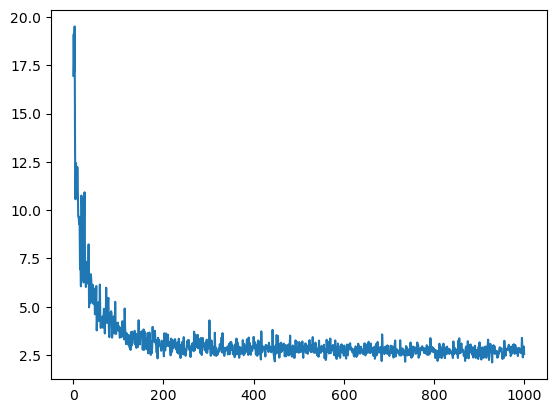

In [308]:
plt.plot(passes, losses)
print('Final loss: ', losses[-1])

## Finding optimal gradient step size
We are going to find the loss after using multiple difference learning rates and then plot the loss as a function of learning rate to find the optimal learning rate ot use

In [330]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10** lre

lrates = []
lossesTest = []

for i in range(1000):
    ''' Contructing a minibatch '''
    ix = torch.randint(0, X.shape[0], (32,))

    ''' Forward Pass: '''
    # Embedding
    emb = C[X[ix]]
    #logits
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    #Loss
    loss = F.cross_entropy(logits, Y[ix])

    ''' Backward Pass: '''
    # Reinitialize gradients
    for p in parameters:
        p.grad = None
    # Calculate the new gradients
    loss.backward()
    # Slightly adjust parameters against gradient direction
    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad
            
    lossesTest.append(loss.item())
    lrates.append(lre[i])

''' Getting final lost by doing a final forward pass '''
# Embedding
emb = C[X[ix]]
#logits
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
#Loss
loss = F.cross_entropy(logits, Y[ix])
lossesTest.append(loss.item())
lrates.append(lre[-1])


### Plotting the loss as a function of the learning rates exponent:

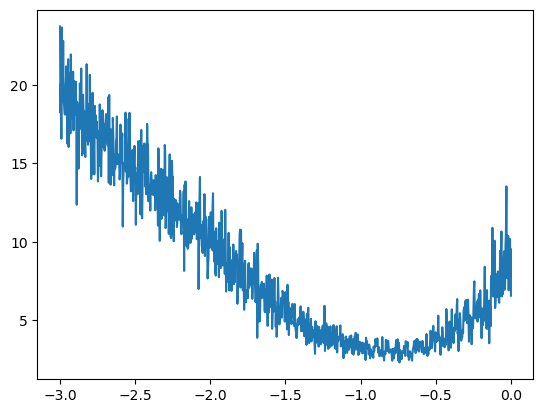

In [332]:
plt.plot(lrates, lossesTest)

So between a good learning rate is between 1**-1.0 and 1**-0.5